In [124]:
# Option Price for European Call and Put Options
# This program calculates the price of European call and put options using the Black-Scholes formula.
import math
import numpy as np
from scipy.stats import norm
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.stats as stats


In [125]:
# Function to calculate the price of European call and put options using the Black-Scholes formula
# Option Params
S = 100  # Current stock price
K = 100  # Option strike price
T = 1  # Time to expiration in years
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility of the underlying stock
q = 0  # Dividend yield

In [126]:
# Function to calculate the price of European call and put options using the Black-Scholes formula
def black_scholes(S, K, T, r, sigma, q):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    call_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(
        d2
    )
    put_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(
        -d1
    )
    return call_price, put_price

In [127]:
# Calculate call and put prices
call_price_benchmark, put_price_benchmark = black_scholes(S, K, T, r, sigma, q)
# Print the results
print(f"Call Price Benchmark: {call_price_benchmark:.2f}")
print(f"Put Price Benchmark: {put_price_benchmark:.2f}")

Call Price Benchmark: 10.45
Put Price Benchmark: 5.57


In [128]:
# Function to calculate the price of European call and put options using binomial tree
def binomial_tree(S, K, T, r, sigma, q, put=False, american=False, n=100):
    """
    Calculate the price of European call and put options using the binomial tree method.
    Parameters:
    S : float : Current stock price
    K : float : Option strike price
    T : float : Time to expiration in years
    r : float : Risk-free interest rate
    sigma : float : Volatility of the underlying stock
    q : float : Dividend yield
    n : int : Number of time steps
    type : str : 'call' for call option, 'put' for put option
    american : bool : True for American option, False for European option
    Returns:
    float : Option price
    """

    # Calculate parameters for the binomial tree
    dt = T / n
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp((r - q) * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    asset_prices = np.zeros((n + 2) * (n + 1) // 2)

    def binomial_index(j, i):
        return (j * (j + 1)) // 2 + i

    for i in range(n + 1):
        asset_prices[binomial_index(n, i)] = S * (u ** (n - i)) * (d ** i)

    # Initialize option values at maturity
    option_values = np.maximum(0, asset_prices - K if not put else K - asset_prices)

    # Backward induction to calculate option price
    for j in range(n - 1, -1, -1):
        for i in range(j + 1):
            expected = (
                               p * option_values[binomial_index(j + 1, i)]
                               + (1 - p) * option_values[binomial_index(j + 1, i + 1)]
                       ) * math.exp(-r * dt)

            if american:
                spot_price = S * (u ** (j - i)) * (d ** i)
                intrinsic = max(0, K - spot_price if put else spot_price - K)
                option_values[binomial_index(j, i)] = max(intrinsic, expected)
            else:
                option_values[binomial_index(j, i)] = expected
    return option_values[0]

In [129]:
# Calculate call and put prices using binomial tree
n = 100  # Number of time steps
call_price_binomial = binomial_tree(S, K, T, r, sigma, q, american=False, n=n)
# put_price_binomial = binomial_tree(S, K, T, r, sigma, q, put=True, american=False, n=1000)
# Print the results
print(f"Call Price Binomial: {call_price_binomial:.2f}")
# print(f"Put Price Binomial: {put_price_binomial:.2f}")

Call Price Binomial: 10.43


In [130]:
# Function to calculate the price of call and put options using trinomial tree
def trinomial_tree(
        S, K, T, r, sigma, q, put=False, american=False, n=100, l=math.sqrt(1.5)
):
    """
    Calculate the price of European call and put options using the trinomial tree method.
    Parameters:
    S : float : Current stock price
    K : float : Option strike price
    T : float : Time to expiration in years
    r : float : Risk-free interest rate
    sigma : float : Volatility of the underlying stock
    q : float : Dividend yield
    put : bool : True for put option, False for call option
    american : bool : True for American option, False for European option
    n : int : Number of time steps
    l : float : Parameter for the trinomial tree
    Returns:
    float : Option price
    """
    # Calculate parameters for the trinomial tree
    dt = T / n
    u = math.exp(l * sigma * math.sqrt(dt))
    d = 1 / u
    m = 1
    p_u = (1 / (2 * l ** 2)) + ((r - q - sigma ** 2 / 2) * math.sqrt(dt)) / (2 * l * sigma)
    p_d = (1 / (2 * l ** 2)) - ((r - q - sigma ** 2 / 2) * math.sqrt(dt)) / (2 * l * sigma)
    p_m = 1 - p_u - p_d

    # Initialize asset prices at maturity
    asset_prices = np.zeros((n + 1) ** 2)
    option_values = np.zeros((n + 1) ** 2)

    def trinomial_index(j, i):
        return j ** 2 + i

    for i in range(2 * n + 1):
        asset_prices[trinomial_index(n, i)] = S * (u ** (n - i))

    # Initialize option values at maturity
    option_values = np.maximum(0, asset_prices - K if not put else K - asset_prices)

    # Backward induction to calculate option price
    for j in range(n - 1, -1, -1):
        for i in range(2 * j + 1):
            expected_value = (
                                     p_u * option_values[trinomial_index(j + 1, i)]
                                     + p_m * option_values[trinomial_index(j + 1, i + 1)]
                                     + p_d * option_values[trinomial_index(j + 1, i + 2)]
                             ) * math.exp(-r * dt)

            if american:
                # Compute spot price at node (j, i)
                spot_price = S * (u ** (j - i))
                intrinsic_value = max(0, K - spot_price if put else spot_price - K)
                option_values[trinomial_index(j, i)] = max(intrinsic_value, expected_value)
            else:
                option_values[trinomial_index(j, i)] = expected_value

    return option_values[0]

In [131]:
# Calculate call and put prices using trinomial tree
call_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, american=False, l=math.sqrt(1.5), n=100)
# put_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, put=True, american=False, l=1, n=1000)
# Print the results
print(f"Call Price Trinomial: {call_price_trinomial:.2f}")
# print(f"Put Price Trinomial: {put_price_trinomial:.2f}")

Call Price Trinomial: 10.44


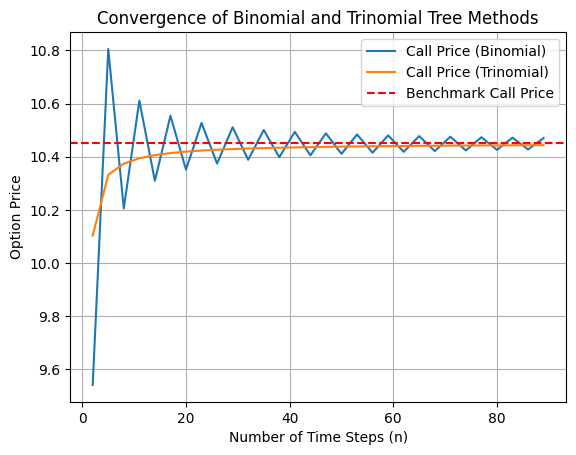

In [132]:
# Plot convergence of binomial and trinomial tree methods
n_values = range(2, 301, 3)

call_prices_binomial = []
put_prices_binomial = []
call_prices_trinomial = []
put_prices_trinomial = []

for n in n_values:
    call_price_binomial = binomial_tree(S, K, T, r, sigma, q, n=n)
    put_price_binomial = binomial_tree(S, K, T, r, sigma, q, put=True, n=n)
    call_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, n=n)
    put_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, put=True, n=n)
    call_prices_binomial.append(call_price_binomial)
    put_prices_binomial.append(put_price_binomial)
    call_prices_trinomial.append(call_price_trinomial)
    put_prices_trinomial.append(put_price_trinomial)

limit = 30
plt.plot(n_values[:limit], call_prices_binomial[:limit], label="Call Price (Binomial)")
# plt.plot(n_values[:limit], put_prices_binomial[:limit], label="Put Price (Binomial)")
plt.plot(n_values[:limit], call_prices_trinomial[:limit], label="Call Price (Trinomial)")
# plt.plot(n_values[:limit], put_prices_trinomial[:limit], label="Put Price (Trinomial)")
plt.axhline(
    y=call_price_benchmark, color="r", linestyle="--", label="Benchmark Call Price"
)
# plt.axhline(
#     y=put_price_benchmark, color="g", linestyle="--", label="Benchmark Put Price"
# )
plt.xlabel("Number of Time Steps (n)")
plt.ylabel("Option Price")
plt.title("Convergence of Binomial and Trinomial Tree Methods")
plt.legend()
plt.grid()
plt.show()

In [133]:
# Find the number of steps for both models when the error < 0.1%
tolerance = 0.001  # 1% tolerance
n_binomial = None
n_trinomial = None

for i in range(2, len(n_values)):  # Increase the range if necessary

    error_binomial = abs(call_prices_binomial[i] - call_price_benchmark) / call_price_benchmark
    error_trinomial = abs(call_prices_trinomial[i] - call_price_benchmark) / call_price_benchmark

    if n_binomial is None and error_binomial < tolerance:
        n_binomial = n_values[i]
    if n_trinomial is None and error_trinomial < tolerance:
        n_trinomial = n_values[i]

    if n_binomial is not None and n_trinomial is not None:
        break

print(f"Number of steps for Binomial Tree to achieve < 0.1% error: {n_binomial}")
print(f"Number of steps for Trinomial Tree to achieve < 0.1% error: {n_trinomial}")

Number of steps for Binomial Tree to achieve < 0.1% error: 173
Number of steps for Trinomial Tree to achieve < 0.1% error: 62


In [134]:
# Timing for Binomial Tree
start_time_binomial = time.time()
binomial_tree(S, K, T, r, sigma, q, n=n_binomial)
end_time_binomial = time.time()
time_binomial = end_time_binomial - start_time_binomial

# Timing for Trinomial Tree
start_time_trinomial = time.time()
trinomial_tree(S, K, T, r, sigma, q, n=n_trinomial)
end_time_trinomial = time.time()
time_trinomial = end_time_trinomial - start_time_trinomial

print(f"Time taken for Binomial Tree with {n_binomial} steps: {time_binomial:.6f} seconds")
print(f"Time taken for Trinomial Tree with {n_trinomial} steps: {time_trinomial:.6f} seconds")

Time taken for Binomial Tree with 173 steps: 0.010859 seconds
Time taken for Trinomial Tree with 62 steps: 0.003870 seconds


In [135]:
# Test for different stock prices
strike_prices = range(80, 121, 10)
steps = range(10, 101, 10)
df_error = pd.DataFrame(columns=["Strike Price", "Steps", "Error Binomial", "Error Trinomial"])
for K in strike_prices:
    call_price_benchmark, put_price_benchmark = black_scholes(S, K, T, r, sigma, q)
    for n in steps:
        call_price_binomial = binomial_tree(S, K, T, r, sigma, q, n=n)
        call_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, n=n)
        error_binomial = (call_price_binomial - call_price_benchmark) / call_price_benchmark
        error_trinomial = (call_price_trinomial - call_price_benchmark) / call_price_benchmark
        new_row = pd.DataFrame([{
            "Strike Price": K,
            "Steps": n,
            "Error Binomial": error_binomial,
            "Error Trinomial": error_trinomial,
        }])

        df_error = pd.concat([df_error, new_row], ignore_index=True)
df_error

/var/folders/z_/mrmcmc9j3nq9_m70z7783tyr0000gn/T/ipykernel_99349/1559607854.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_error = pd.concat([df_error, new_row], ignore_index=True)


,Strike Price,Steps,Error Binomial,Error Trinomial
0,80,10,0.001042,-0.000664
1,80,20,0.000973,-0.000574
2,80,30,-0.000864,-0.000522
3,80,40,0.000496,-0.000019
4,80,50,-0.000459,0.000075
5,80,60,0.000174,-0.000207
6,80,70,0.000216,0.000047
7,80,80,-0.000417,-0.000082
8,80,90,0.000091,0.000032
9,80,100,0.000190,-0.000088


In [136]:
# Test for American options

import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval

K = 100

import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval


def american_option_lsmc(S0, K, r, sigma, T, M, N, put=False):
    """
    Value an American option (put or call) using Least Squares Monte Carlo (LSMC).

    Parameters:
        S          : initial stock price
        K           : strike price
        r           : risk-free rate
        sigma       : volatility
        T           : time to maturity (in years)
        M           : number of time steps
        N           : number of simulation paths
        put         : True for put option, False for call option

    Returns:
        Estimated option price
    """
    dt = T / M
    discount = np.exp(-r * dt)

    # Step 1: Simulate paths
    Z = np.random.randn(N, M)
    S = np.zeros((N, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Step 2: Payoff function
    if put:
        payoff = np.maximum(K - S, 0)
    else:
        payoff = np.maximum(S - K, 0)

    cashflow = payoff[:, -1]

    # Step 3: Backward induction
    for t in range(M - 1, 0, -1):
        itm = payoff[:, t] > 0  # in-the-money paths
        X = S[itm, t]
        Y = cashflow[itm] * discount

        if len(X) == 0:
            continue

        # Step 4: Regression to estimate continuation value
        coeffs = polyfit(X, Y, deg=2)
        continuation_value = polyval(X, coeffs)

        # Step 5: Exercise decision
        exercise = payoff[itm, t] > continuation_value
        exercise_indices = np.where(itm)[0][exercise]
        cashflow[exercise_indices] = payoff[exercise_indices, t]

        # Discount all cashflows (including exercised ones)
        cashflow *= discount

    # Step 6: Final discounted value
    return np.mean(cashflow) * np.exp(-r * dt)

In [137]:
call_price_mc_ame = american_option_lsmc(S, K, r-q, sigma, T, M=100, N=10000, put=False)
print(call_price_mc_ame)

10.16071047296698


In [138]:
call_price_binomial_ame = binomial_tree(S, K, T, r, sigma, q, american=True, n=3)
call_price_trinomial_ame = trinomial_tree(S, K, T, r, sigma, q, american=True, n=100)
print(call_price_binomial_ame)
print(call_price_trinomial_ame)

11.043871091951113
10.44423244072359


In [209]:
def binomial_tree_with_dividends(S, K, T, r, sigma, dividends=[], put=False, american=False, n=100):
    dt = T / n
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)

    # Step 1: Adjust initial stock price
    S_adj = S - sum(D * math.exp(-r * t) for t, D in dividends)

    # Map dividend time to step
    dividend_steps = {int(t / T * n): D for t, D in dividends}

    def binomial_index(j, i):
        return (j * (j + 1)) // 2 + i

    asset_prices = np.zeros((n + 2) * (n + 1) // 2)

    # Step 2: Initialize stock prices at maturity
    for i in range(n + 1):
        asset_prices[binomial_index(n, i)] = S_adj * (u ** (n - i)) * (d ** i)

    # Step 3: Backward induction with dividend adjustment
    option_values = np.maximum(0, K - asset_prices if put else asset_prices - K)

    for j in range(n - 1, -1, -1):
        for i in range(j + 1):
            idx = binomial_index(j, i)
            S_node = S_adj * (u ** (j-i)) * (d ** i)
            # Discounted expected value
            cont_value = (
                p * option_values[binomial_index(j + 1, i)] +
                (1 - p) * option_values[binomial_index(j + 1, i + 1)]
            ) * math.exp(-r * dt)

            # Restore dividend at this node if applicable
            if j in dividend_steps:
                S_node += dividend_steps[j]

            # print(f"S_node in {j}, {i}: {S_node}")

            if american:
                # Intrinsic value for American options
                intrinsic = max(0, K - S_node if put else S_node - K)
                # print(f"Intrinsic in {j}, {i}: {intrinsic}")
                option_values[idx] = max(cont_value, intrinsic)
            else:
                option_values[idx] = cont_value

            # Update asset price for this node
            asset_prices[binomial_index(j, i)] = S_node
    # print(option_values)
    return option_values[0]

In [208]:
def trinomial_tree_with_dividends(
    S, K, T, r, sigma, dividends=[], put=False, american=False, n=100, l=math.sqrt(1.5)
):
    dt = T / n
    u = math.exp(l * sigma * math.sqrt(dt))
    d = 1 / u
    m = 1
    p_u = (1 / (2 * l ** 2)) + ((r - sigma ** 2 / 2) * math.sqrt(dt)) / (2 * l * sigma)
    p_d = (1 / (2 * l ** 2)) - ((r - sigma ** 2 / 2) * math.sqrt(dt)) / (2 * l * sigma)
    p_m = 1 - p_u - p_d

    # Adjust initial stock price for PV of dividends
    S_adj = S - sum(D * math.exp(-r * t) for t, D in dividends)

    # Map dividend time to time step
    dividend_steps = {int(t / T * n): D for t, D in dividends}

    # Indexing helper
    def trinomial_index(j, i):
        return j ** 2 + i

    # Initialize asset prices at maturity
    asset_prices = np.zeros((n + 1) ** 2)
    for i in range(2 * n + 1):
        j = n - i
        asset_prices[trinomial_index(n, i)] = S_adj * (u ** j)

    # Initialize option values at maturity
    option_values = np.maximum(
        0, K - asset_prices if put else asset_prices - K
    )

    # Backward induction
    for j in range(n - 1, -1, -1):
        for i in range(2 * j + 1):
            idx = trinomial_index(j, i)
            S_node = S_adj * (u ** (j - i))
            cont_value = (
                p_u * option_values[trinomial_index(j + 1, i)] +
                p_m * option_values[trinomial_index(j + 1, i + 1)] +
                p_d * option_values[trinomial_index(j + 1, i + 2)]
            ) * math.exp(-r * dt)

            # If there's a dividend at this step, restore the cash dividend
            if j in dividend_steps:
                S_node += dividend_steps[j]

            # print(f"S_node in {j}, {i}: {S_node}")
            if american:
                # Intrinsic value if American
                intrinsic = max(0, K - S_node if put else S_node - K)

                # print(f"Intrinsic in {j}, {i}: {intrinsic}")
                # Future values (discounted)


                option_values[idx] = max(cont_value, intrinsic)

            else:
                option_values[idx] = cont_value

            # Update asset price for this node
            asset_prices[idx] = S_node
    # print(option_values)
    return option_values[0]

In [202]:
call_price_div_binomial = binomial_tree_with_dividends(S, K, T, r, sigma, american=True, dividends=[(0.25, 2.0), (0.75, 1.5)], n=3)
# put_price_binomial = binomial_tree(S, K, T, r, sigma, q, put=True, n=n)
call_price_div_trinomial = trinomial_tree_with_dividends(S, K, T, r, sigma, american=True, dividends=[(0.25, 2.0), (0.75, 1.5)], n=3, l=1)
print(call_price_div_binomial)
print(call_price_div_trinomial)

S_node in 2, 0: 123.1699845154647
Intrinsic in 2, 0: 23.169984515464705
S_node in 2, 1: 98.080052772431
Intrinsic in 2, 1: 0
S_node in 2, 2: 78.16399096434479
Intrinsic in 2, 2: 0
S_node in 1, 0: 108.40153839002676
Intrinsic in 1, 0: 8.401538390026758
S_node in 1, 1: 86.0477326434671
Intrinsic in 1, 1: 0
S_node in 0, 0: 98.580052772431
Intrinsic in 0, 0: 0
[ 8.8265271  14.48874523  2.40283173 23.32283913  4.4930483   0.
 36.56250042  8.40153839  0.          0.        ]
S_node in 2, 0: 123.1699845154647
Intrinsic in 2, 0: 23.169984515464705
S_node in 2, 1: 109.90153839002676
Intrinsic in 2, 1: 9.901538390026758
S_node in 2, 2: 98.080052772431
Intrinsic in 2, 2: 0
S_node in 2, 3: 87.5477326434671
Intrinsic in 2, 3: 0
S_node in 2, 4: 78.16399096434479
Intrinsic in 2, 4: 0
S_node in 1, 0: 108.40153839002676
Intrinsic in 1, 0: 8.401538390026758
S_node in 1, 1: 96.580052772431
Intrinsic in 1, 1: 0
S_node in 1, 2: 86.0477326434671
Intrinsic in 1, 2: 0
S_node in 0, 0: 98.580052772431
Intrinsic

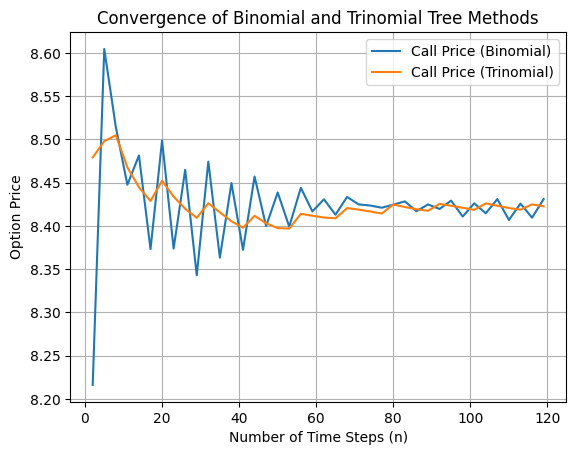

In [216]:
# Plot convergence of binomial and trinomial tree methods
n_values = range(2, 301, 3)

call_prices_div_binomial = []
# put_prices_binomial = []
call_prices_div_trinomial = []
# put_prices_trinomial = []

for n in n_values:
    call_price_div_binomial = binomial_tree_with_dividends(S, K, T, r, sigma, american=True, dividends=[(0.25, 2.0), (0.75, 1.5)], n=n)
    # put_price_binomial = binomial_tree(S, K, T, r, sigma, q, put=True, n=n)
    call_price_div_trinomial = trinomial_tree_with_dividends(S, K, T, r, sigma, american=True, dividends=[(0.25, 2.0), (0.75, 1.5)], n=n)
    # put_price_trinomial = trinomial_tree(S, K, T, r, sigma, q, put=True, n=n)
    call_prices_div_binomial.append(call_price_div_binomial)
    # put_prices_div_binomial.append(put_price_binomial)
    call_prices_div_trinomial.append(call_price_div_trinomial)
    # put_prices_div_trinomial.append(put_price_trinomial)

limit = 40
plt.plot(n_values[:limit], call_prices_div_binomial[:limit], label="Call Price (Binomial)")
# plt.plot(n_values[:limit], put_prices_binomial[:limit], label="Put Price (Binomial)")
plt.plot(n_values[:limit], call_prices_div_trinomial[:limit], label="Call Price (Trinomial)")
# plt.plot(n_values[:limit], put_prices_trinomial[:limit], label="Put Price (Trinomial)")
# plt.axhline(
#     y=call_price_benchmark, color="r", linestyle="--", label="Benchmark Call Price"
# )
# plt.axhline(
#     y=put_price_benchmark, color="g", linestyle="--", label="Benchmark Put Price"
# )
plt.xlabel("Number of Time Steps (n)")
plt.ylabel("Option Price")
plt.title("Convergence of Binomial and Trinomial Tree Methods")
plt.legend()
plt.grid()
plt.show()